In [69]:
import requests
import json
import pandas as pd
import numpy as np

import seaborn as sns

In [90]:
fondstyret = "https://www.shareville.no/api/v1/portfolios/324475/positions"
min_portefølje = "https://www.shareville.no/api/v1/portfolios/360442/positions"

raw_data = pd.read_json(fondstyret, orient="records")

raw_data = pd.concat([raw_data.drop(['instrument'], axis=1), raw_data['instrument'].apply(pd.Series)], axis=1)
raw_data = pd.concat([raw_data.drop(['acq_price_acc'], axis=1), raw_data['acq_price_acc'].apply(pd.Series)], axis=1)

raw_data.head()

,is_custom_gav,percent,buy_fee,category,comment_count,country,currency,has_fund_data,has_ucits,id,...,stream_count_1d,symbol,tradables,underlyings,updated_at,performance_three_years,rating,performance_five_years,currency,value
0,False,9.829026,0.0,"USA, Store selskaper, Blandet",0,None,NOK,True,True,177068,...,0,F00000XM0A,"[{'tick_size_id': 14729, 'lot_size': 1.0, 'ide...","[{'symbol': 'KLP AksjeUSA Indeks USD A', 'isin...",2019-06-12T15:44:56.023818Z,NaN,NaN,NaN,NOK,1343.762325
1,False,7.423966,0.0,Norge,71,None,NOK,True,True,174355,...,2,F00000TH8U,"[{'tick_size_id': 14729, 'lot_size': 1.0, 'ide...","[{'symbol': 'GJF', 'isin_code': 'NO0010582521'...",2019-06-12T15:58:25.398115Z,49.12,4.0,NaN,NOK,139.798864
2,False,7.502103,0.0,Finland,82,None,EUR,True,True,174450,...,1,F00000TH8W,"[{'tick_size_id': 14729, 'lot_size': 1.0, 'ide...","[{'symbol': 'NDA FI', 'isin_code': 'FI40002977...",2019-06-12T15:58:31.986824Z,46.47,5.0,NaN,NOK,1553.150366
3,False,7.446892,0.0,Danmark,35,None,DKK,True,True,174371,...,1,F00000TH8X,"[{'tick_size_id': 14729, 'lot_size': 1.0, 'ide...","[{'symbol': 'ORSTED', 'isin_code': 'DK00600949...",2019-06-12T15:58:14.575636Z,23.56,2.0,NaN,NOK,190.435629
4,False,19.932695,0.0,"Europa, Store selskaper, Blanding",1,None,NOK,True,True,177072,...,0,F00000VCTO,"[{'tick_size_id': 14729, 'lot_size': 1.0, 'ide...","[{'symbol': 'AZN.UK', 'isin_code': 'GB00098952...",2019-06-12T15:35:37.615171Z,28.87,3.0,46.62,NOK,107.299603


In [91]:
raw_data.columns

Index(['is_custom_gav', 'percent', 'buy_fee', 'category', 'comment_count',
       'country', 'currency', 'has_fund_data', 'has_ucits', 'id', 'institute',
       'instrument_group_type', 'instrument_id', 'instrument_type',
       'is_daily_traded', 'isin_code', 'last_nav', 'last_nav_date',
       'management_fee', 'mifid2_category', 'min_investment', 'multiplier',
       'name', 'no_of_decimals', 'occurence_prc', 'org_info',
       'pawn_percentage', 'performance_one_day', 'performance_one_month',
       'performance_one_week', 'performance_this_year', 'price_type',
       'prospectus_url', 'sector', 'sector_group', 'sell_fee', 'slug',
       'status', 'stream_count', 'stream_count_1d', 'symbol', 'tradables',
       'underlyings', 'updated_at', 'performance_three_years', 'rating',
       'performance_five_years', 'currency', 'value'],
      dtype='object')

In [93]:
key_data = raw_data[["name", "symbol", "percent", "management_fee", "performance_one_week", "performance_this_year", "performance_three_years", "performance_five_years"]]
key_data

,name,symbol,percent,management_fee,performance_one_week,performance_this_year,performance_three_years,performance_five_years
0,KLP AksjeUSA Indeks III,F00000XM0A,9.829026,0.20,2.13,15.88,NaN,NaN
1,Nordnet Superfondet Norge,F00000TH8U,7.423966,0.00,1.94,9.33,49.12,NaN
2,Nordnet Superrahasto Suomi,F00000TH8W,7.502103,0.00,2.48,10.05,46.47,NaN
3,Nordnet Superfonden Danmark,F00000TH8X,7.446892,0.00,2.94,13.55,23.56,NaN
4,Handelsbanken Europafond Index (A1 NOK),F00000VCTO,19.932695,0.20,2.07,13.45,28.87,46.62
5,KLP AksjeFremvoksende Markeder Indeks II,F00000MKDH,20.041731,0.30,1.67,7.18,39.23,55.54
6,KLP AksjeGlobal LavBeta I,F00000RW2R,19.702790,0.27,1.42,13.12,31.62,91.16
7,Nordnet Superfonden Sverige,F000002J6V,7.524649,0.00,2.59,9.77,29.29,52.42


In [94]:
startdate = '2015-01-01'

data = []

# Morningstar loop to get historical prices         
for index, row in key_data.iterrows():
    payload = {"id": row["symbol"], "currencyId": "NOK", "idtype": "Morningstar", "frequency": "daily", "startDate": startdate, "outputType": "COMPACTJSON"}
    data = requests.get("http://tools.morningstar.no/api/rest.svc/timeseries_price/nen6ere626", params=payload)
    result = data.text
    jsondecode = json.loads(result)
    
    if index == 0:
        df = pd.DataFrame(jsondecode, columns=["Timestamp", row["name"]])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='ms')
    else:
        temp = pd.DataFrame(jsondecode, columns=["Timestamp", row["name"]])
        df[row["name"]] = temp[row["name"]]
       
df.head()

(1097, 2)
(1112, 2)
(1094, 2)
(1118, 2)
(1103, 2)
(1084, 2)
(1114, 2)


,Timestamp,KLP AksjeUSA Indeks III,Nordnet Superfondet Norge,Nordnet Superrahasto Suomi,Nordnet Superfonden Danmark,Handelsbanken Europafond Index (A1 NOK),KLP AksjeFremvoksende Markeder Indeks II,KLP AksjeGlobal LavBeta I,Nordnet Superfonden Sverige
0,2016-09-19,1000.000,91.27,918.307,123.590,85.977,1408.278,1360.580,251.735
1,2016-09-20,1001.464,88.93,898.418,122.099,86.503,1397.001,1347.506,251.358
2,2016-09-21,1015.458,90.29,898.974,121.247,84.572,1403.894,1352.638,247.741
3,2016-09-22,995.766,91.44,903.036,121.119,85.629,1423.475,1366.278,248.956
4,2016-09-23,992.068,91.49,901.136,121.510,84.867,1430.722,1372.314,247.471


Text(0.5,1,'Corrolation matrix of Assets')

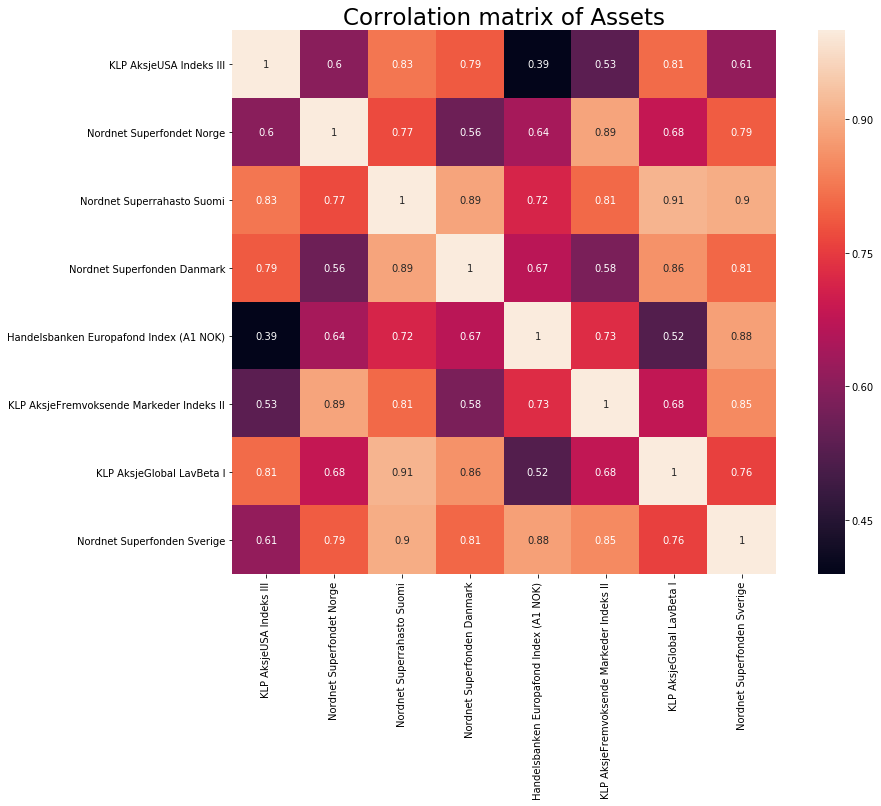

In [96]:
corr_matrix = df.drop("Timestamp", axis=1).corr()
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, vmax=1.0, annot=True, square=True)
plt.title('Corrolation matrix of Assets', fontsize=23)

In [101]:
# create the correlation matrix

 
# portfolio weights
w = np.array(key_data.percent * 0.01)
print(w)
# portfolio volatility
portfolio_volatility = np.sqrt(w.T.dot(corr_matrix).dot(w))
print(portfolio_volatility)

[0.09829026 0.07423966 0.07502103 0.07446892 0.19932695 0.20041731
 0.1970279  0.07524649]
0.860610862780821
